# Start sensitivity (range of best vs worst start)

Compute the range between the best and worst starting image **within each subset**, then apply hierarchical bootstrap across tasks/datasets using the helpers in `hierarchical_ci.py`.

In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


def normalize_metric(series, metric_name):
    """Flip sign for metrics where lower is better."""
    if metric_name in {'iterations_used', 'iterations_mean'}:
        return -series
    return series

REPO_ROOT = Path('.').resolve()
if not (REPO_ROOT / 'experiments').exists():
    REPO_ROOT = REPO_ROOT.parent
sys.path.insert(0, str(REPO_ROOT))

from experiments.analysis.planb_utils import load_planb_summaries
from experiments.analysis.hierarchical_ci import (
    aggregate_permutation,
    compute_subset_stat,
    hierarchical_bootstrap_dataset_stat,
)


# ---- Config ----
procedure = 'random_v_MSE_v2'
ablation = 'pretrained_baseline5p'
policy_name = 'random'
dataset = 'BTCV'  # or None for all
metric = 'initial_dice'
n_boot = 1000
seed = 0

def range_reducer(arr):
    arr = np.asarray(arr, dtype=float)
    if arr.size == 0:
        return np.nan
    return float(arr.max() - arr.min())

In [2]:
# ---- Load Plan B summaries ----
df = load_planb_summaries(
    repo_root=REPO_ROOT,
    procedure=procedure,
    ablation=ablation,
    dataset=dataset,
)
df = df[df['policy_name'] == policy_name].copy()
df[metric] = normalize_metric(df[metric], metric)
if df.empty:
    raise ValueError('No rows after filtering by policy.')

# Per-permutation mean score across images
per_perm = aggregate_permutation(df, metric)

# Identify start image per permutation (image_index == 0)
start_rows = (
    df[df['image_index'] == 0]
    [['subset_index', 'task_id', 'policy_name', 'permutation_index', 'image_id']]
    .drop_duplicates()
    .rename(columns={'image_id': 'start_image_id'})
)

# Attach start image to permutation-level scores
per_perm = per_perm.merge(
    start_rows,
    on=['subset_index', 'task_id', 'policy_name', 'permutation_index'],
    how='inner',
)

if per_perm.empty:
    raise ValueError('No permutation rows after attaching start image.')

# Average permutation scores by start image (within subset)
per_start = (
    per_perm.groupby(
        ['subset_index', 'task_id', 'policy_name', 'start_image_id'],
        as_index=False,
    )[metric].mean()
    .rename(columns={metric: 'start_mean'})
)

# Build a synthetic df where each 'permutation' = start image
start_df = per_start.rename(
    columns={'start_image_id': 'permutation_index', 'start_mean': metric}
)

start_df.head()


,subset_index,task_id,policy_name,permutation_index,initial_dice
0,0,BTCV/BTCV_Cervix_CT_0_label0_maxslice_idx640,random,1,0.734003
1,0,BTCV/BTCV_Cervix_CT_0_label0_maxslice_idx640,random,2,0.738356
2,0,BTCV/BTCV_Cervix_CT_0_label0_maxslice_idx640,random,3,0.702979
3,0,BTCV/BTCV_Cervix_CT_0_label0_maxslice_idx640,random,6,0.735145
4,0,BTCV/BTCV_Cervix_CT_0_label0_maxslice_idx640,random,7,0.669686


In [ ]:
# ---- Subset-level range (best - worst start) ----

range_df = compute_subset_stat(
    start_df,
    metric,
    reducer=range_reducer,
    stat_name='start_range',
)

range_df.head()


NameError: name 'start_df' is not defined

In [4]:
# ---- Hierarchical bootstrap on subset ranges ----
stats = hierarchical_bootstrap_dataset_stat(
    start_df,
    metric,
    policy_name,
    reducer=range_reducer,
    stat_name='start_range',
    n_boot=n_boot,
    seed=seed,
)

print(
    'Dataset range mean={:.4f} CI=({:.4f}, {:.4f}) n_boot={}'.format(
        stats['mean'], stats['ci_lo'], stats['ci_hi'], stats['n_boot']
    )
)


Dataset range mean=0.0776 CI=(0.0754, 0.0797) n_boot=1000


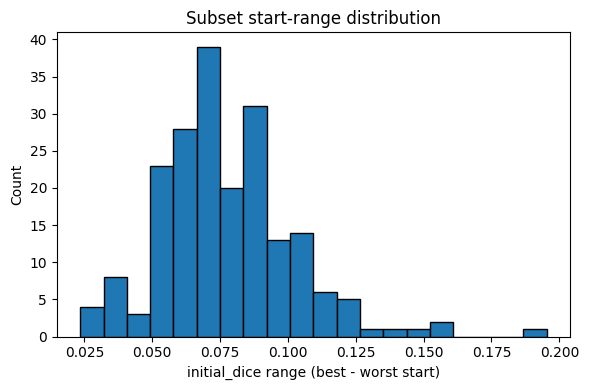

In [5]:
# ---- Optional: visualize subset-level ranges ----
plt.figure(figsize=(6, 4))
plt.hist(range_df['start_range'].dropna(), bins=20, edgecolor='black')
plt.title('Subset start-range distribution')
plt.xlabel(f'{metric} range (best - worst start)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


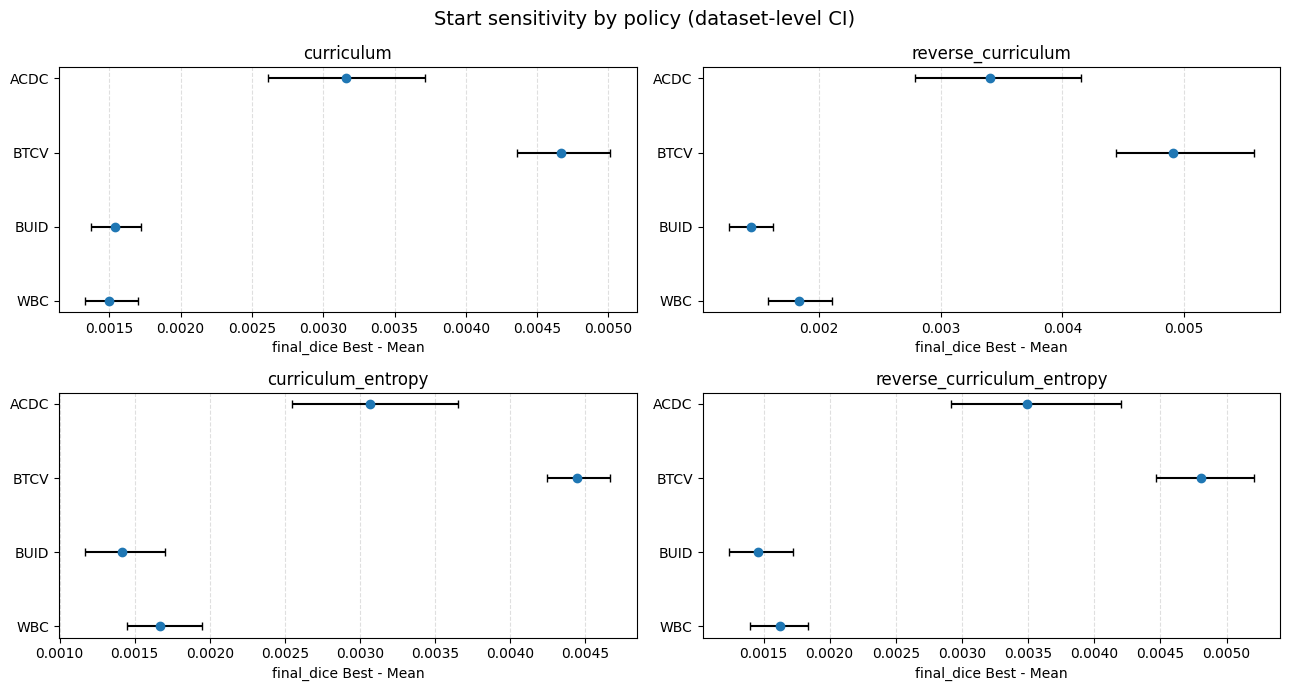

In [19]:
# ---- Grid of forest plots (one per policy) ----
policies = [
    'curriculum',
    'reverse_curriculum',
    'curriculum_entropy',
    'reverse_curriculum_entropy',
]
# policies = [
#     'random'
# ]
# policies = [
#     'mse_min',
#     'mse_max',
#     'mse_alternate_start_min',
#     'mse_alternate_start_max',
# ]
procedure = 'random_vs_uncertainty_v2'
ablation = 'pretrained_baseline'
metric = 'final_dice'
datasets = ['ACDC', 'BTCV', 'BUID', 'WBC']
measure = 'iqr'

# Controls what varies within each subset before hierarchical bootstrap.
# - 'permutation': current behavior (best-worst across permutations)
# - 'start': collapse permutations by start image, then best-worst across starts
sensitivity_mode = 'start'  # or 'start'
if sensitivity_mode not in {'permutation', 'start'}:
    raise ValueError("sensitivity_mode must be 'permutation' or 'start'.")

# Load all datasets once, then filter per panel
df_all = load_planb_summaries(
    repo_root=REPO_ROOT,
    procedure=procedure,
    ablation=ablation,
    dataset=None,
)

def sensitive_mean_to_max_reducer(arr):
    arr = np.asarray(arr, dtype=float)
    return arr.max() - arr.mean()

def sensitive_mean_to_min_reducer(arr):
    arr = np.asarray(arr, dtype=float)
    return arr.mean() - arr.min()

def iqr_reducer(arr):
    arr = np.asarray(arr, dtype=float)
    return np.quantile(arr, 0.75) - np.quantile(arr, 0.25)

def build_start_df(df_pol, metric):
    # Build synthetic frame where each 'permutation' is a start image.
    per_perm = aggregate_permutation(df_pol, metric)
    start_rows = (
        df_pol[df_pol['image_index'] == 0]
        [['subset_index', 'task_id', 'policy_name', 'permutation_index', 'image_id']]
        .drop_duplicates()
        .rename(columns={'image_id': 'start_image_id'})
    )
    per_perm = per_perm.merge(
        start_rows,
        on=['subset_index', 'task_id', 'policy_name', 'permutation_index'],
        how='inner',
    )
    if per_perm.empty:
        return per_perm

    per_start = (
        per_perm.groupby(
            ['subset_index', 'task_id', 'policy_name', 'start_image_id'],
            as_index=False,
        )[metric].mean()
        .rename(columns={metric: 'start_mean'})
    )

    # Reuse hierarchical helpers by renaming start id to permutation_index.
    return per_start.rename(columns={'start_image_id': 'permutation_index', 'start_mean': metric})

reducer = None
if sensitivity_mode == 'start' and 'dice' in metric:
    reducer = sensitive_mean_to_max_reducer
    spread_label = 'Best - Mean'
    stat_name = 'dice_start_sensitivity'
elif sensitivity_mode == 'start' and 'iterations_used' == metric:
    reducer = sensitive_mean_to_min_reducer
    spread_label = 'Mean - Best'
    stat_name = 'iter_start_sensitivity'
elif measure == 'iqr':
    reducer = iqr_reducer
    spread_label = '0.75Q - 0.25Q Percentile'
    stat_name = 'permutation_iqr'
elif measure == 'range':
    reducer = range_reducer
    spread_label = 'Best - Worst'
    stat_name = 'permutation_range'

def dataset_sensitivity_stats(df_all, policy, dataset, metric, n_boot, seed):
    df_pol = df_all[(df_all['policy_name'] == policy) & (df_all['family'] == dataset)].copy()
    if df_pol.empty:
        return None

    if sensitivity_mode == 'start':
        stat_df = build_start_df(df_pol, metric)
    else:
        stat_df = df_pol
    if stat_df.empty:
        return None

    stats = hierarchical_bootstrap_dataset_stat(
        stat_df,
        metric,
        policy,
        reducer=reducer,
        stat_name=stat_name,
        n_boot=n_boot,
        seed=seed,
    )
    return stats

ncols = 2
nrows = int(np.ceil(len(policies) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6.5 * ncols, 3.5 * nrows), sharex=False)
axes = np.array(axes).reshape(-1)

for ax, policy in zip(axes, policies):
    means = []
    los = []
    his = []
    labels = []
    for ds in datasets:
        stats = dataset_sensitivity_stats(df_all, policy, ds, metric, n_boot, seed)
        if stats is None:
            continue
        means.append(stats['mean'])
        los.append(stats['ci_lo'])
        his.append(stats['ci_hi'])
        labels.append(ds)
    if not labels:
        ax.set_title(f'{policy} (no data)')
        ax.axis('off')
        continue

    y = np.arange(len(labels))
    xerr = [np.array(means) - np.array(los), np.array(his) - np.array(means)]
    ax.errorbar(means, y, xerr=xerr, fmt='o', color='tab:blue', ecolor='black', capsize=3)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_xlabel(f'{metric} {spread_label}')
    ax.set_title(policy)
    ax.grid(True, axis='x', linestyle='--', alpha=0.4)

# Hide unused axes
for ax in axes[len(policies):]:
    ax.axis('off')

fig.suptitle(
    f"{sensitivity_mode.capitalize()} sensitivity by policy (dataset-level CI)",
    fontsize=14,
)
plt.tight_layout()
plt.show()

